In [124]:
!pip install --upgrade git+http://github.com/nikitadurasov/masksembles
!wget https://github.com/nikitadurasov/masksembles/raw/main/images/complex_sample_mnist.npy

# MNIST 

## Keras

In [113]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt

In [3]:
from masksembles.keras import Masksembles2D, Masksembles1D

In [6]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In order to transform regular model into Masksembles model one should add Masksembles2D or Masksembles1D layers in it. General recommendation is to insert these layers right before or after convolutional layers. 

In example below we'll use both Masksembles2D and Masksembles1D layers applied after convolutions. 

In [29]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="elu"),
        Masksembles2D(4, 2.0), # adding Masksembles2D
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="elu"),
        Masksembles2D(4, 2.0), # adding Masksembles2D
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Flatten(),
        Masksembles1D(4, 2.), # adding Masksembles1D
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
masksembles2d_6 (Masksembles (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
masksembles2d_7 (Masksembles (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)             

Training of Masksembles is not different from training of regular model. So we just use standard fit Keras API.

In [30]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 54s 126ms/step - loss: 1.0014 - accuracy: 0.7048 - val_loss: 0.1698 - val_accuracy: 0.9520
Epoch 2/5
422/422 [==============================] - 53s 125ms/step - loss: 0.1825 - accuracy: 0.9455 - val_loss: 0.1100 - val_accuracy: 0.9693
Epoch 3/5
422/422 [==============================] - 53s 125ms/step - loss: 0.1235 - accuracy: 0.9628 - val_loss: 0.0824 - val_accuracy: 0.9773
Epoch 4/5
422/422 [==============================] - 53s 126ms/step - loss: 0.0961 - accuracy: 0.9706 - val_loss: 0.0791 - val_accuracy: 0.9767
Epoch 5/5
422/422 [==============================] - 53s 125ms/step - loss: 0.0850 - accuracy: 0.9742 - val_loss: 0.0674 - val_accuracy: 0.9827


After training we could check that all of Masksembles' submodels would predict similar predictions for training samples.

In [118]:
img = x_train[0] # just random image from training set

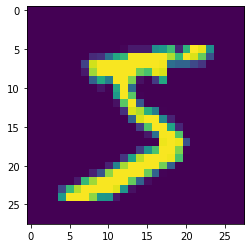

In [119]:
plt.imshow(img[..., 0])
plt.show()

To acquire predictions from different submodels one should transform input (with shape [1, H, W, C]) into batch (with shape [M, H, W, C]) that consists of M copies of original input (H - height of image, W - width of image, C - number of channels).

As we can see Masksembles submodels produce similar predictions for training set samples.

In [120]:
inputs = np.tile(img[None], [4, 1, 1, 1])
predictions = model(inputs)
for i, cls in enumerate(tf.argmax(predictions, axis=1)):
    print(f"PREDICTION OF {i+1} MODEL: {cls} CLASS")

PREDICTION OF 1 MODEL: 5 CLASS
PREDICTION OF 2 MODEL: 5 CLASS
PREDICTION OF 3 MODEL: 5 CLASS
PREDICTION OF 4 MODEL: 5 CLASS


On out-of-distribution samples Masksembles should produce predictions with high variance, let's check it on complex samples from MNIST.

In [121]:
img = np.load("./complex_sample_mnist.npy")

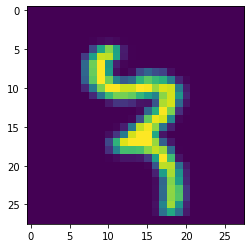

In [122]:
plt.imshow(img[..., 0])

In [123]:
inputs = np.tile(img[None], [4, 1, 1, 1])
predictions = model(inputs)
for i, cls in enumerate(tf.argmax(predictions, axis=1)):
    print(f"PREDICTION OF {i+1} MODEL: {cls} CLASS")

PREDICTION OF 1 MODEL: 3 CLASS
PREDICTION OF 2 MODEL: 7 CLASS
PREDICTION OF 3 MODEL: 7 CLASS
PREDICTION OF 4 MODEL: 7 CLASS
